In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
# Load Teams from KenPom and ESPN
from selenium import webdriver
from march_sadness import KPTeam, ESPNTeam, CombinedTeam


# Set up Selenium webdriver with GeckoDriver
options = webdriver.FirefoxOptions()
options.add_argument('-headless')
with webdriver.Firefox(options=options) as driver:
    kp_teams = KPTeam.list_all(driver)
print(f'Loaded {len(kp_teams)} teams from KenPom')

espn_teams = ESPNTeam.list_all()

print(f'Loaded {len(espn_teams)} teams from ESPN')


Loaded 363 teams from KenPom
Loaded 360 teams from ESPN


In [3]:
from fuzzywuzzy import fuzz


def edge_weight(espn_team: ESPNTeam, kp_team: KPTeam):
    # Special cases for the problem children
    if espn_team.id == '41' or kp_team.name == 'Connecticut':
        return 1 if espn_team.id == '41' and kp_team.name == 'Connecticut' else 0
    if espn_team.id == '82' or kp_team.name == 'Illinois Chicago':
        return 1 if espn_team.id == '82' and kp_team.name == 'Illinois Chicago' else 0
    if espn_team.id == '112358' or kp_team.name == 'LIU':
        return 1 if espn_team.id == '112358' and kp_team.name == 'LIU' else 0

    disp_ratio = fuzz.ratio(espn_team.displayName, kp_team.name)
    nick_ratio = fuzz.ratio(espn_team.nickname, kp_team.name)
    lin_weight = max(disp_ratio, nick_ratio) / 100
    return lin_weight


teams = CombinedTeam.combine(espn_teams, kp_teams, edge_weight)
print(f'Loaded {len(teams)} combined teams')


Loaded 360 combined teams


In [4]:
def get_team(name):
    def fuzz_name(x): return fuzz.ratio(name, x)

    def single_match(x): return fuzz_name(max(x.espn.displayName,
                                              x.espn.nickname, x.espn.abbreviation, x.kp.name, key=fuzz_name))
    match = max(teams, key=single_match)
    return match


In [5]:
def get_team_by_id(id):
    matches = [team for team in teams if team.espn.id == id]
    if len(matches) > 0:
        return matches[0]
    return None

In [6]:
import pandas as pd
from dataclasses import asdict
from IPython.display import display

def kpdata(matchupTeams):
    df = pd.DataFrame(({
        **{k: v for k, v in asdict(x.kp).items() if k not in ['name', 'conf']}
    } for x in matchupTeams), index=(x.espn.displayName for x in matchupTeams))
    df.loc['Difference'] = df.iloc[0] - df.iloc[1]
    return df


In [7]:
import requests


def get_schedule(team):
    if 'schedule' in team.misc:
        return team.misc['schedule'], False
    response = requests.get(f'https://site.api.espn.com/apis/site/v2/sports/basketball/mens-college-basketball/teams/{team.espn.id}/schedule?seasontype=2')
    schedule = [x['competitions'][0] for x in response.json()['events']]
    games = []
    for game in schedule:
        if not game['status']['type']['completed']:
            continue
        opp = game['competitors'][0]
        this = game['competitors'][1]
        if opp['id'] == team.espn.id:
            opp, this = this, opp
        opp_team = get_team_by_id(opp['id'])
        if opp_team:
            games.append((opp['id'], this['score']['value'] - opp['score']['value']))
    team.misc['schedule'] = games
    return team.misc['schedule'], True

In [8]:
import numpy as np


def hex2rgb(c):
    l = len(c)
    return np.fromiter((int(c[i:i + l // 3], 16) / 255 for i in range(0, l, l // 3)), np.float64)

def color_diff(c1, c2):
    cdiff = hex2rgb(c1) - hex2rgb(c2)
    return np.sqrt(np.dot(cdiff, cdiff))

def select_colors(t1, t2, min_diff=0.2, min_dark=0.2):
    attempts = [
        (t1.espn.color, t2.espn.color),
        (t1.espn.color, t2.espn.alternateColor),
        (t1.espn.alternateColor, t2.espn.color),
        (t1.espn.alternateColor, t2.espn.alternateColor)
    ]

    for c1, c2 in attempts:
        if c1 is not None and c2 is not None and color_diff(c1, c2) > min_diff and color_diff(c1, 'ffffff') > min_dark and color_diff(c2, 'ffffff') > min_dark:
            return '#' + c1, '#' + c2
        

    return 'C0', 'C1'

In [9]:
def get_stats(team):
    if 'stats' in team.misc:
        return team.misc['stats'], False
    team.misc['stats'] = {k: v for k, v in asdict(team.kp).items() if k not in [
        'name', 'conf'] and '_rk' not in k}

    response = requests.get(f'https://site.api.espn.com/apis/site/v2/sports/basketball/mens-college-basketball/teams/{team.espn.id}/statistics?seasontype=2')
    stat_cats = response.json()['results']['stats']['categories']
    for cat in stat_cats:
        for stat in cat['stats']:
            if 'avg' in stat['name']:
                team.misc['stats'][stat['name']] = stat['value']    
    return team.misc['stats'], True


for team in teams:
    if 'stats' in team.misc:
        del team.misc['stats']


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import linregress


def graph_stat(matchupTeams, per_line=2, figsize=(12, 12)):
    schedules = [get_schedule(team)[0] for team in matchupTeams]
    stats = [get_stats(team)[0] for team in matchupTeams]
    ys = [[y[1] for y in team] for team in schedules]

    opps = [[get_team_by_id(opp[0]) for opp in team] for team in schedules]

    fig, ax = plt.subplots(int(np.ceil(len(stats[0]) / per_line)), per_line, figsize=figsize)

    regressions = [{}, {}]
    for i, k in enumerate(stats[0]):
        row = i // per_line
        col = i % per_line
        colors = select_colors(matchupTeams[0], matchupTeams[1])
        for j in range(2):
            data = [(get_stats(opp)[0][k], y) for opp, y in zip(opps[j], ys[j]) if k in get_stats(opp)[0]]
            x_set = np.array([x[0] for x in data])
            y_set = np.array([x[1] for x in data])
            x_lin = np.linspace(np.min(x_set), np.max(x_set))

            regressions[j][k] = linregress(x_set, y_set)
            ax[row][col].scatter(x_set, y_set, c=colors[j], label=matchupTeams[j].espn.abbreviation, s=12)
            ax[row][col].plot(x_lin, regressions[j][k].intercept + regressions[j][k].slope * x_lin, ':', c=colors[j])
            ax[row][col].axvline(stats[j][k], c=colors[j])
        ax[row][col].set_title(k)
        ax[row][col].legend()
        ax[row][col].spines['right'].set_color('none')
        ax[row][col].yaxis.tick_left()
        ax[row][col].spines['bottom'].set_position('zero')
        ax[row][col].spines['top'].set_color('none')
        ax[row][col].xaxis.tick_bottom()
        ax[row][col].autoscale(enable=True) 

    return fig, regressions


In [11]:
def stat_regressions(correlation):
    regressions_list = list(correlation.items())
    regressions_list.sort(key=lambda x: abs(x[1].rvalue), reverse=True)

    df = pd.DataFrame(columns=['R-Value', 'Slope', 'P-value'])
    for k, v in regressions_list:
        df.loc[k] = v.rvalue, v.slope, v.pvalue
    return df



Wake Forest Demon Deacons vs. Purdue Boilermakers
Retrived schedule for Wake Forest Demon Deacons
Retrived stats for All opponents                  
Loaded stats
Retrived schedule for Purdue Boilermakers
Retrived stats for All opponents              
Loaded stats


,adjEM,adjO,adjO_rk,adjD,adjD_rk,adjT,adjT_rk,oppEM,oppEM_rk,oppO,oppO_rk,oppD,oppD_rk,ncEM,ncEM_rk
Wake Forest Demon Deacons,8.61,112.1,60.0,103.5,134.0,69.6,63.0,4.97,83.0,108.0,82.0,103.1,85.0,-2.18,238.0
Purdue Boilermakers,24.60,119.3,9.0,94.7,23.0,64.3,323.0,9.88,19.0,110.5,15.0,100.6,41.0,1.04,139.0
Difference,-15.99,-7.2,51.0,8.8,111.0,5.3,-260.0,-4.91,64.0,-2.5,67.0,2.5,44.0,-3.22,99.0


Correlations for Wake Forest Demon Deacons:


,R-Value,Slope,P-value
adjEM,-0.686653,-0.848843,0.000010
adjD,0.630760,1.311436,0.000083
adjO,-0.559773,-1.237963,0.000706
oppO,-0.480792,-2.819281,0.004622
oppEM,-0.480303,-1.744133,0.004670
oppD,0.432991,3.723959,0.011838
avgSteals,-0.410438,-4.542536,0.017669
avgAssists,-0.385777,-2.762201,0.026603
avgDefensiveRebounds,-0.364327,-2.505810,0.037119
avgFieldGoalsMade,-0.335365,-2.236202,0.056403


Correlations for Purdue Boilermakers:


,R-Value,Slope,P-value
adjD,0.650520,1.314702,0.000031
adjEM,-0.557264,-0.561365,0.000618
oppO,-0.511495,-2.111463,0.001989
oppEM,-0.479598,-0.988153,0.004103
avgTurnovers,0.463654,2.759828,0.005748
oppD,0.418016,1.612464,0.013891
ncEM,0.397475,0.902125,0.019923
adjO,-0.354191,-0.540980,0.039862
adjT,0.220939,1.156028,0.209230
avgFouls,0.184011,1.701531,0.297525


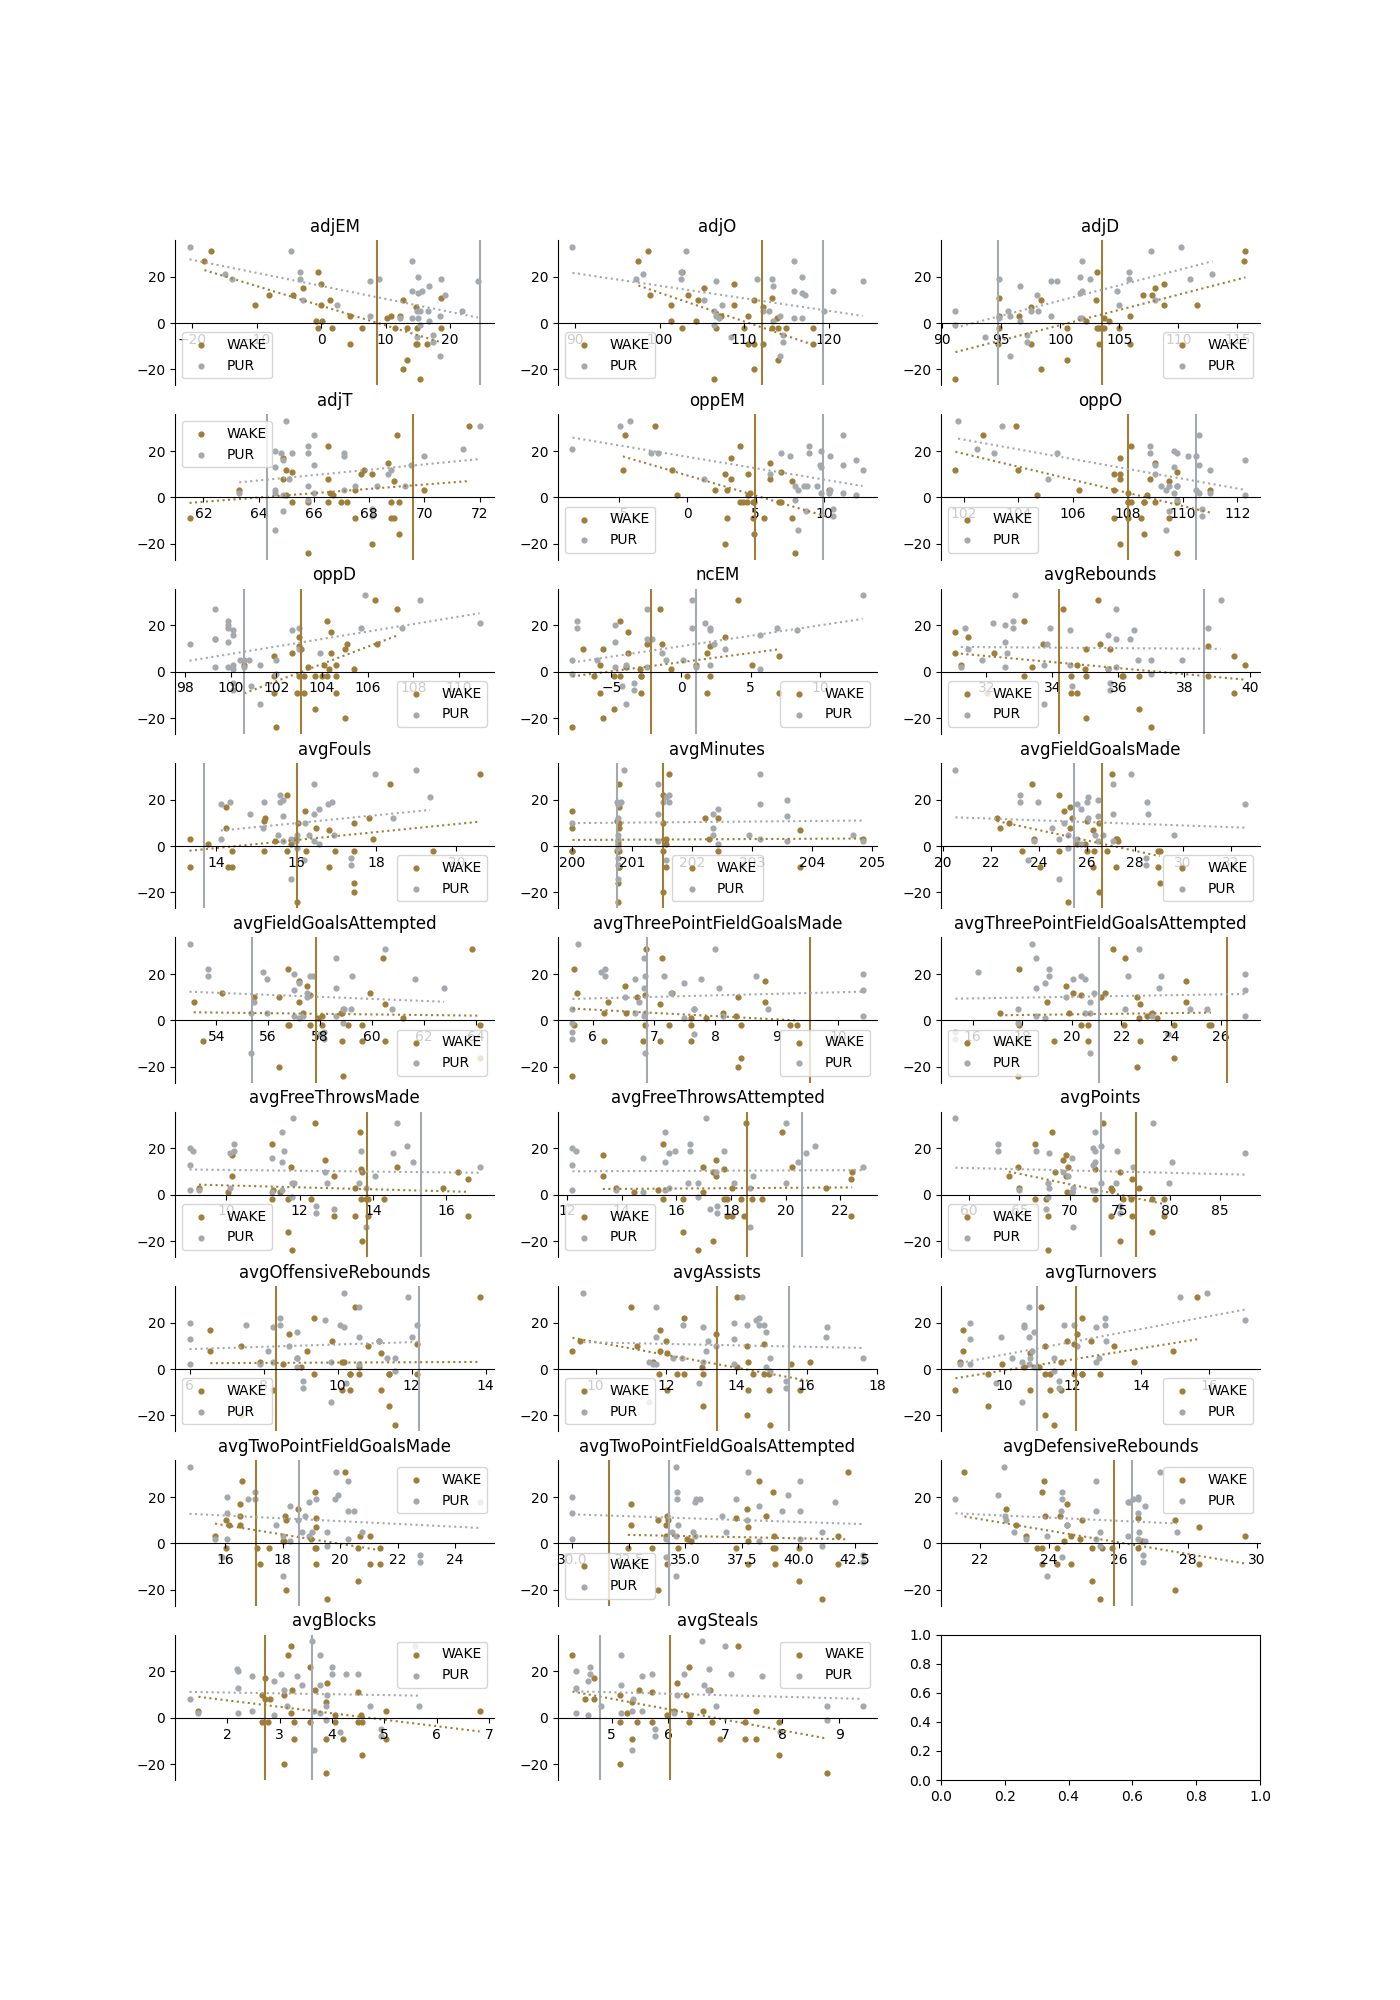

In [12]:
matchupNames = ['Wake Forest', 'PUR']



%matplotlib widget

matchupTeams = [get_team(x) for x in matchupNames]
print(f'{matchupTeams[0].espn.displayName} vs. {matchupTeams[1].espn.displayName}')

for team in matchupTeams:
    get_stats(team)
    schedule, did_req = get_schedule(team)
    if did_req:
        print(f'Retrived schedule for {team.espn.displayName}')
    opp_gen = (get_team_by_id(x[0]) for x in schedule)
    last_len = 0
    for opp in opp_gen:
        _, did_req = get_stats(opp)
        if did_req:
            spacer = ' ' * max(last_len - len(opp.espn.displayName), 1)
            print(f'Retrived stats for {opp.espn.displayName}{spacer}', end='\r')
            last_len = len(opp.espn.displayName)
        msg = 'All opponents'
        spacer = ' ' * max(last_len - len(msg), 1)
        print(f'Retrived stats for {msg}{spacer}', end='\r')
    print('\nLoaded stats')


display(kpdata(matchupTeams))
fig, regressions = graph_stat(matchupTeams, per_line=3, figsize=(14, 20))

for i in range(2):
    print(f'Correlations for {matchupTeams[i].espn.displayName}:')
    display(stat_regressions(regressions[i]))